# IMU error

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
imu_df = pd.read_csv("imu_data.csv")
slam_df = pd.read_csv("slam_data.csv")

In [4]:
def calc_average_vel_imu(stamps: np.ndarray, velocities: np.ndarray) -> float:
    """Calculate the average velocity for the imu"""
    return velocities.mean()

def unnormalize_orientation(orientations: np.ndarray) -> np.ndarray:
    """The orientation data is unnormalized meaning that the values can be outside the range of [-pi, pi]."""
    orient_diffs = np.diff(orientations)
    normalization_steps = (np.abs(orient_diffs) >= np.pi).astype(int) * -np.sign(orient_diffs)
    return orientations + 2 * np.pi * np.insert(np.cumsum(normalization_steps), 0, 0)

### 1. Calculate the average velocity for the SLAM and the IMU

### 2. Calculate the biases and MSSDs

The **bias** is expressed as the factor with which the average velocity from the IMU differs from the average velocity SLAM.

$$bias = \frac{v_{avg,IMU} - v_{avg,SLAM}}{v_{avg,SLAM}}$$

The **variance** is estimate with the Mean Square Successive Difference (MSSD)

In [5]:
def calculate_bias(vel_imu: float, vel_slam: float) -> float:
    """Calculate the bias as a factor of the slam velocity"""
    # return (vel_imu - vel_slam) / vel_slam
    return (vel_imu - vel_slam) / vel_slam


def MSSD(values: np.ndarray) -> float:
    """Calculate the Mean Square Successive Difference (MSSD)"""
    return 0.5 * (np.sum((values[:-1] - values[1:]) ** 2) / (len(values) - 1)).astype(float)

In [6]:
# Iterate over the different experiments and calculate the bias and mssd for each one

results_dict = {
    "velocities imu": [],
    "velocities slam": [],
    "biases": [],
    "mssds": [],
}
for number in pd.unique(imu_df["numbers"]):
    imu_df_part = imu_df[imu_df["numbers"] == number]
    slam_df_part = slam_df[slam_df["numbers"] == number]

    ### 1. Calculate the average velocity
    # imu average velocity
    avg_velocity_imu = imu_df_part["angular velocities"].mean()
    avg_velocity_imu = np.sum(imu_df_part["angular velocities"].to_numpy()[:-1] * np.diff(imu_df_part["stamps"].to_numpy())) / np.sum(np.diff(imu_df_part["stamps"].to_numpy()))
    # slam average velocity
    orients_unnorm = unnormalize_orientation(slam_df_part["orientations"].to_numpy())
    rotation = orients_unnorm[-1] - orients_unnorm[0]
    duration = slam_df_part["stamps"].iloc[-1] - slam_df_part["stamps"].iloc[0]
    avg_velocity_slam = rotation / duration

    results_dict['velocities imu'].append(avg_velocity_imu)
    results_dict['velocities slam'].append(avg_velocity_slam)


    ### 2. Calculate the biases and MSSDs
    bias = calculate_bias(avg_velocity_imu, avg_velocity_slam)
    mssd = MSSD(imu_df_part["angular velocities"].to_numpy())

    results_dict["biases"].append(bias)
    results_dict["mssds"].append(mssd)

results_df = pd.DataFrame.from_dict(results_dict)
results_df["errors"] = results_df["velocities imu"] - results_df["velocities slam"]
results_df

,velocities imu,velocities slam,biases,mssds,errors
0,0.306289,0.357913,-0.144238,0.000435,-0.051625
1,0.472821,0.557143,-0.151347,0.000363,-0.084322
2,0.646993,0.767551,-0.157067,0.000610,-0.120557
3,0.800498,0.956999,-0.163533,0.000586,-0.156501
4,0.973137,1.162762,-0.163081,0.000984,-0.189625
5,1.145994,1.316355,-0.129419,0.000997,-0.170362
6,1.321463,1.544703,-0.144520,0.001572,-0.223240
7,1.491885,1.763132,-0.153844,0.001974,-0.271247


In [7]:
from scipy.optimize import least_squares

"""Error as function of the measured velocity"""


def fun_error(bias, velocity, error):
    """Model the error as function of the wheel encoder velocity, where `bias` is the calibration factor"""
    return bias * velocity - error


# the IMU velocities and errors
imu_vels, errors = results_df["velocities imu"].to_numpy(), results_df["errors"].to_numpy()

bias0 = 0.001
res = least_squares(fun_error, bias0, args=(imu_vels, errors))
opt_bias = res.x.squeeze()  # the optimal calibration factor

### 3. Visualize

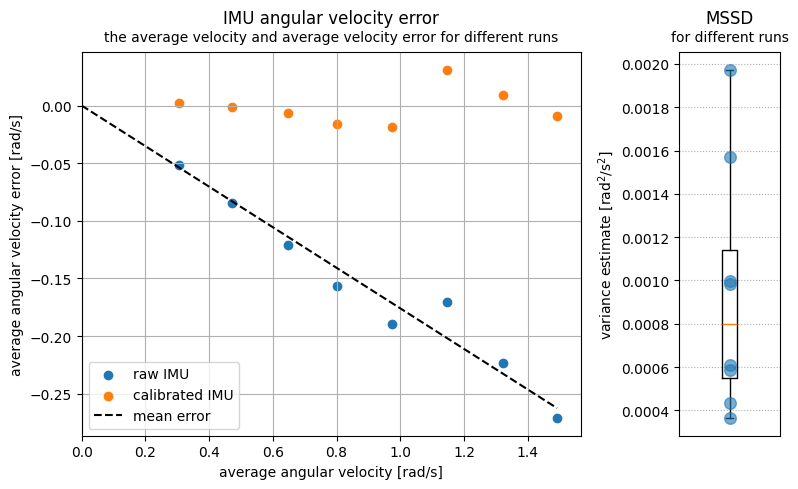

In [8]:
mssds, velocities, errors = (
    results_df["mssds"].to_numpy(),
    results_df["velocities imu"].to_numpy(),
    results_df["errors"].to_numpy(),
)

fig = plt.figure(figsize=(8, 5))
# fig = plt.figure(figsize=(6.4, 4.8))

std_dev = np.sqrt(mssds).max()

ax = fig.add_subplot(1, 4, (1, 3))
ax.scatter(velocities, errors, label="raw IMU")
new_errors = (1 - opt_bias) * velocities - results_df["velocities slam"].to_numpy()
ax.scatter(velocities, new_errors, label="calibrated IMU")

line_x, line_y = np.vstack([[0, 0], [velocities.max(), opt_bias * velocities.max()]]).T
ax.plot(line_x, line_y, "k--", label="mean error")
# ax.fill_between(line_x, line_y - std_dev, line_y + std_dev, alpha=0.3, facecolor="tab:blue")
# ax.fill_between(
#     line_x, -np.full_like(line_y, std_dev), np.full_like(line_y, std_dev), alpha=0.3, facecolor="tab:orange"
# )

ax.legend()
# ax.set_ylim(top=0)
ax.set_xlim(left=0)
ax.set_xlabel("average angular velocity [rad/s]")
ax.set_ylabel("average angular velocity error [rad/s]")
ax.set_title("IMU angular velocity error\n")
ax.text(
    0.5,
    1.03,
    "the average velocity and average velocity error for different runs",
    fontsize=10,
    ha="center",
    transform=ax.transAxes,
)
ax.grid()

ax = fig.add_subplot(1, 4, 4)
# stds = np.sqrt(mssds)
ax.boxplot(mssds)
ax.scatter(np.full_like(mssds, 1), mssds, zorder=10, s=70, alpha=0.6)
# ax.set_ylabel("angular velocity" + r"$^2$" +" [rad" + r"$^2$" + "/s" + r"$^2$" + "]")
ax.set_ylabel("variance estimate" + " [rad" + r"$^2$" + "/s" + r"$^2$" + "]")
ax.set_title("MSSD\n")
ax.text(0.5, 1.03, "for different runs", fontsize=10, ha="center", transform=ax.transAxes)
# ax.set_xticklabels(["mssd"])
ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.yaxis.grid(ls=":")

plt.tight_layout()
plt.savefig("imu_error_fit.png", bbox_inches="tight")
plt.savefig("imu_error_fit.pdf", bbox_inches="tight")
plt.show()